In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [3]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======


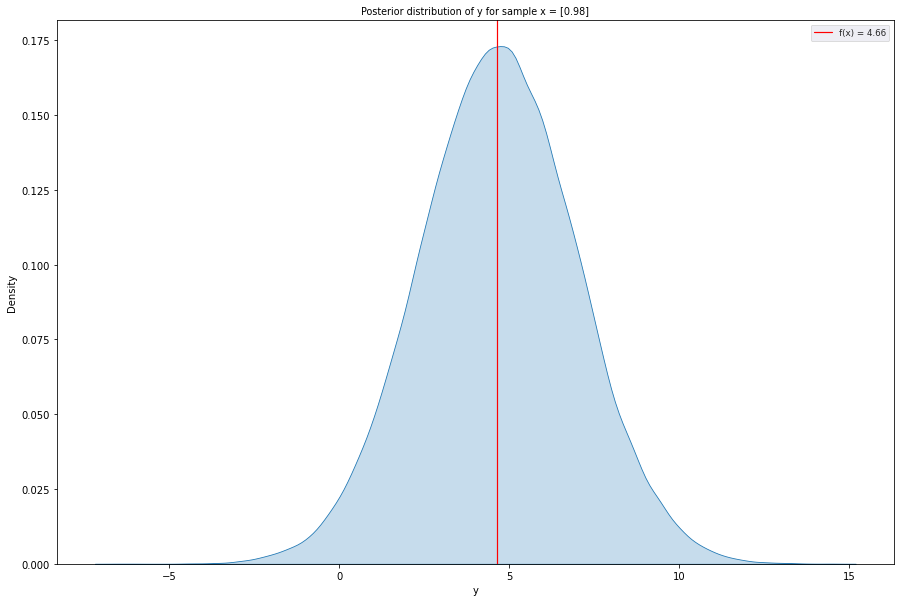

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])


In [7]:
x_train.shape, y_train.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

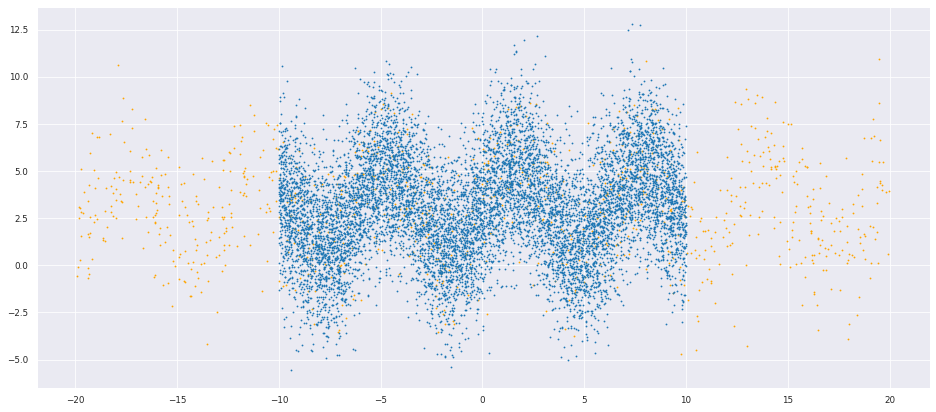

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32,32), nn.ReLU(), nn.Linear(32, 1))
net

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [13]:
print(len(x_train))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(5.), constraint=dist.constraints.positive))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Normal(0, 1))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=1.0)
#obs_model = tyxe.likelihoods.SigmaDistGaussian(len(x_train), scale_loc=0.01, scale_scale=0.01)

#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train), scale=5.0)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d
#likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

likelihood_guide_builder = None


10000


In [14]:
obs_model._scale

tensor(5., grad_fn=<AddBackward0>)

In [15]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [16]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [17]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 300, callback)

epoch: 0 | elbo: 31788.638968552215


KeyboardInterrupt: 

In [ ]:
#pickle.dump(bnn, open(f"{BASE_DIR}/models/{NAME}.pkl", "wb"))

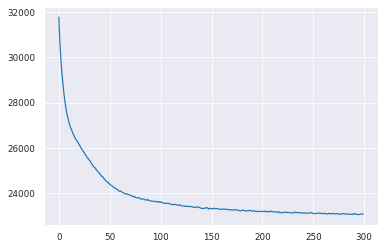

In [ ]:
plt.plot(elbos)

In [ ]:
trace = poutine.trace(bnn.guide).get_trace(x_test[0], y_test[0])

In [ ]:
trace.nodes.keys()

odict_keys(['_INPUT', 'net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net.0.weight', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net.0.bias', 'net_guide.net.2.weight.loc', 'net_guide.net.2.weight.scale', 'net.2.weight', 'net_guide.net.2.bias.loc', 'net_guide.net.2.bias.scale', 'net.2.bias', 'net_guide.net.4.weight.loc', 'net_guide.net.4.weight.scale', 'net.4.weight', 'net_guide.net.4.bias.loc', 'net_guide.net.4.bias.scale', 'net.4.bias', '_RETURN'])

In [ ]:
trace.nodes["net_guide.net.0.weight.scale"]["value"]

tensor([[0.0352],
        [0.0152],
        [0.0413],
        [0.0076],
        [0.0049],
        [0.0082],
        [0.0067],
        [0.0077],
        [0.0028],
        [0.0094],
        [0.0080],
        [0.0295],
        [0.0401],
        [0.0020],
        [0.0355],
        [0.0380],
        [0.0365],
        [0.0061],
        [0.0099],
        [0.0393],
        [0.0344],
        [0.0267],
        [0.0092],
        [0.0221],
        [0.0137],
        [0.0016],
        [0.0062],
        [0.0161],
        [0.0296],
        [0.0056],
        [0.0041],
        [0.0043]], grad_fn=<AddBackward0>)

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
#with tyxe.poutine.local_reparameterization():   
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

# For heteroskedastic aggregate False
#m, sd = torch.split(preds, 1, dim=2)
#means = m.mean(dim=0).detach().cpu()
#stds = sd.mean(dim=0).detach().cpu()

# For homoskedastic aggregate False
#means = preds.mean(dim=0).detach().cpu()
#stds = preds.std(dim=0).detach().cpu()
#minimum = preds.min(dim=0).values.detach().cpu()
#maximum = preds.max(dim=0).values.detach().cpu()

#k5 = preds.kthvalue(int(len(preds) * 0.01), dim=0).values.detach().cpu()
#k95 = preds.kthvalue(int(len(preds) * 0.99), dim=0).values.detach().cpu()

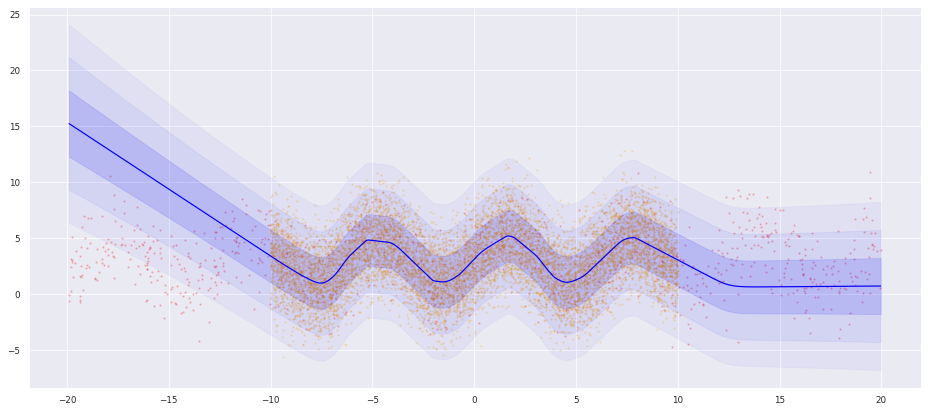

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

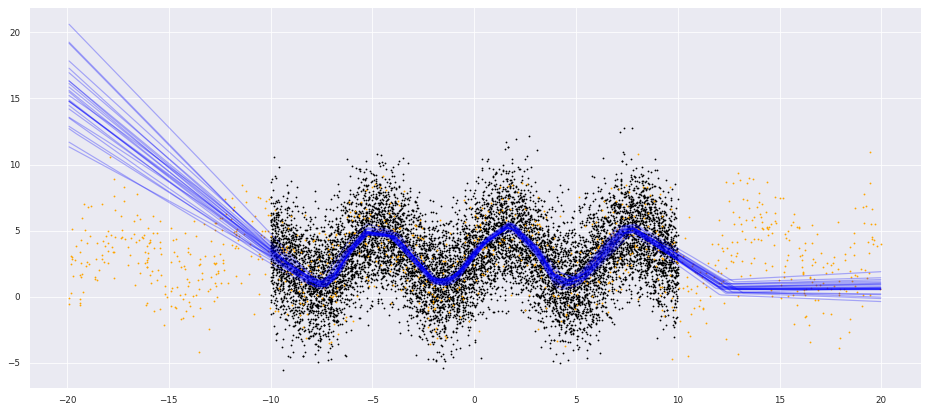

In [ ]:


sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)